In [1]:
from pathlib import Path
import gc
import glob
import os
import json
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
import torch
from joblib import Parallel, delayed
from PIL import Image
from functools import partial
%matplotlib inline
seed=42

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf

# Move fastai weight to .fastai model dir

In [3]:
!mkdir ../../tmp/.fastai
!mkdir ../../tmp/.fastai/models
!cp -a ../input/fastai-wt103-1/. ../../tmp/.fastai/models/
!ls ../../tmp/.fastai/models

wt103-1.tgz


In [4]:
mercari_path = Path('../input/mercari-price-suggestion-challenge/')

In [5]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [ ]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *

In [13]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

In [14]:
def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()

    all_df = preprocess_text_cols(all_df)
    train_df = all_df[~all_df.price.isnull()]
    test_df = all_df[all_df.price.isnull()]
    del all_df
    gc.collect()
    
    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train_df = train_df.loc[sample].reset_index(drop=True)
        
    test_df= test_df.drop('price',axis=1)    
    return train_df,test_df


def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [15]:
n=1482535 # train shape

In [16]:
train_df,test_df = preprocess_all()
train_df.shape,test_df.shape

((1481661, 8), (3460725, 7))

In [18]:
train_df.price = np.log1p(train_df['price']) # so we can use MSE in NN

In [19]:
cat_names=['category1','category2','category3','brand_name','shipping']
# cont_names= list(set(train.columns) - set(cat_names) - {'AdoptionSpeed'})
cont_names= list(set(train_df.columns) - set(cat_names) - {'price','text'})
print(f'# of continuous feas: {len(cont_names)}')
print(f'# of categorical feas: {len(cat_names)}')
dep_var = 'price'
procs = [FillMissing,Categorify, Normalize]

txt_cols=['text']

len(cat_names) + len(cont_names) + 2 == train_df.shape[1]

# of continuous feas: 1
# of categorical feas: 5


True

In [20]:
train_idxs,val_idxs = get_val_idxs(train_df)
train_idxs,val_idxs

(array([      0,       1,       2,       3, ..., 1481656, 1481658, 1481659, 1481660]),
 array([     31,      83,      94,     166, ..., 1481628, 1481634, 1481653, 1481657]))

In [24]:

def get_tab_databunch(train_df,bs=100,val_idxs=val_idxs,path = Path("../")):
    return (TabularList.from_df(train_df, cat_names, cont_names, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
                            .add_test(TabularList.from_df(test_df, cat_names, cont_names,path=path))
                            .databunch(bs=bs))

def get_tabular_learner(data,params,seed=42):
    return tabular_learner(data,metrics=[root_mean_squared_error],
                           callback_fns=[partial(SaveModelCallback, monitor='root_mean_squared_error',mode='min',every='improvement',name='best_nn')],
                           **params)

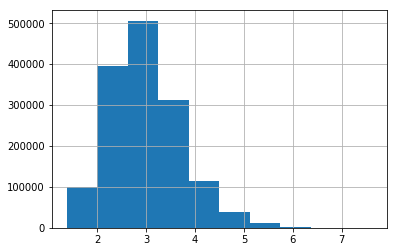

In [25]:
train_df.price.hist()

In [26]:
params={
    'layers':[500,400,200],
#     'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}

In [27]:
tab_db = get_tab_databunch(train_df[cat_names + cont_names+ [dep_var]],bs=3000)

In [28]:
tab_learner = get_tabular_learner(tab_db,params)

In [29]:
tab_learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(11, 6)
    (1): Embedding(114, 23)
    (2): Embedding(871, 71)
    (3): Embedding(4728, 183)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=287, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=400, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [30]:
tab_learner.fit_one_cycle(10,max_lr = 1e-03,pct_start=.3,moms=(0.95, 0.85))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.310442,0.310060,0.556738,00:55
1,0.306022,0.302005,0.549462,00:54
2,0.302766,0.298544,0.546304,00:54
3,0.299149,0.295683,0.543686,00:54
4,0.294052,0.295768,0.543760,00:54
5,0.291382,0.293488,0.541664,00:55
6,0.290783,0.292693,0.540934,00:55
7,0.287305,0.292046,0.540337,00:54
8,0.285417,0.291896,0.540195,00:54
9,0.284482,0.292003,0.540298,00:55


Better model found at epoch 0 with root_mean_squared_error value: 0.5567381978034973.
Better model found at epoch 1 with root_mean_squared_error value: 0.5494620203971863.
Better model found at epoch 2 with root_mean_squared_error value: 0.5463040471076965.
Better model found at epoch 3 with root_mean_squared_error value: 0.5436857342720032.
Better model found at epoch 5 with root_mean_squared_error value: 0.5416635870933533.
Better model found at epoch 6 with root_mean_squared_error value: 0.5409343838691711.
Better model found at epoch 7 with root_mean_squared_error value: 0.5403366684913635.
Better model found at epoch 8 with root_mean_squared_error value: 0.5401949286460876.


In [31]:
# tab_learner.save('nn_full')

In [32]:
test_pred=np.squeeze(to_np(tab_learner.get_preds(DatasetType.Test)[0]))

In [33]:
test_ids = pd.read_table(mercari_path/'test_stg2.tsv')['test_id']

In [41]:
submit = pd.concat([test_ids,pd.Series(np.expm1(test_pred))],axis=1)
submit.columns = ['test_id','price']
submit.to_csv("./submission.csv", index=False)

In [43]:
1+1

2